In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state
from keras.models import Sequential
from keras.layers import GRU, Masking, Dense, Input

global_state.set_global_attribute("torch_device", "cpu")
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [3]:
species_to_keep = [
	# 'time',
	# blood species
	'Cent.Teff_1_0',
	'Cent.Treg',
	'Cent.nT_CD4',
	'Cent.nT_CD8',
	'Cent.Nivo',
	# lymph node species
	'LN.Nivo',
	'LN.APC',
	'LN.mAPC',
	'LN.nT_CD8',
	'LN.nT_CD4',
	'LN.Treg',
	'LN.aTreg_CD4',
	'LN.IL2',
	'LN.Cp',
	'LN.D1_0',
	'LN.aT_1_0',
	'LN.Teff_1_0',
	# tumor species
	'Tum.Nivo',
	'Tum.APC',
	'Tum.mAPC',
	'Tum.C1',
	'Tum.Cp',
	'Tum.Ckine_Mat',
	'Tum.Treg',
	'Tum.Teff_PD1',
	'Tum.D1_0',
	'Tum.Teff_1_0',
	'Tum.Teff_exhausted',
	'Tum.DAMP',
	'Tum.C1_PDL1',
	'Tum.C1_PDL2'
]

In [4]:
# get all QSP_0.csv files from the experiments folder
exp_dir = '../qsp_experiments/hpc1_10k_pd1pdl1/outputs/subject_1'
num_samples = 5000
num_test_samples = 1000
total_samples = 10000
# get the total number of samples
total_idx = np.random.choice(total_samples, num_samples + num_test_samples,replace=False)
data_idx = total_idx[:num_samples]
test_idx = total_idx[num_samples:]

In [87]:
# get text_idx, but exclude the data_idx samples
qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in data_idx]

# def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
observables = [np.load(path)['arr_0'] for path in qsp_paths]
observables = np.concatenate(observables, axis=0)
species_idx = range(17)
names_to_keep = [species_to_keep[i] for i in species_idx]

In [97]:
def observables_processor(obs):
	obs = obs[:,:,species_idx]

	sigma = 1e-2
	# epsilon = 1e-8
	noise = np.random.normal(0, sigma, obs.shape)
	# data = np.exp(np.log(observables + epsilon) + noise) - epsilon
	# data[data <= 0] = 1e-16 
	# data = np.log(data)
	obs += noise
	obs[obs <= 0] = np.abs(noise[obs <= 0])

	# thin = 4 * 7
	# obs = obs[:,::thin,:]

	# set all but a fraction of the time points to a constant value
	# discard_idx = np.random.choice([True,False], size=obs.shape[:2], p=[0.9, 0.1])
	# discard_idx = np.broadcast_to(np.expand_dims(discard_idx,axis=2), obs.shape)
	# obs[discard_idx] = np.nan

	return obs

data = observables_processor(observables)

def data_gen(**kwargs):
	idx = kwargs['idx']
	data_out = data[idx]
	data_list = [data_out[:,i] for i in range(data_out.shape[-1])]
	return dict(zip(names_to_keep, data_list))

# params
params_df = pd.read_csv(os.path.join(exp_dir,'param_log.csv'), index_col=0, header=0)
param_names = list(params_df.columns)
# remove everything before the final forward slash
param_names = [name.split('/')[-1] for name in param_names]

def params_processor(params_df,idx):
		params = params_df.to_numpy()[idx]
		return params
params = params_processor(params_df,data_idx)

def params_prior():
	idx = np.random.choice(params.shape[0])
	p_out = params[idx]
	out = dict(zip(param_names, p_out))
	out['idx'] = idx
	return out

In [100]:
simulator = bf.make_simulator([params_prior, data_gen])
simulator.sample(1)

{'Kd_PD1_PDL1': array([[6.99699]]),
 'idx': array([[1087]]),
 'Cent.Teff_1_0': array([[5.35678e+10, 5.35736e+10, 5.35789e+10, ..., 2.03325e+09,
         2.03407e+09, 2.03491e+09]]),
 'Cent.Treg': array([[1.17828e+08, 1.17843e+08, 1.17857e+08, ..., 6.87296e+07,
         6.87842e+07, 6.88396e+07]]),
 'Cent.nT_CD4': array([[5.16e+09, 5.16e+09, 5.16e+09, ..., 5.16e+09, 5.16e+09, 5.16e+09]]),
 'Cent.nT_CD8': array([[3.03e+09, 3.03e+09, 3.03e+09, ..., 3.03e+09, 3.03e+09, 3.03e+09]]),
 'Cent.Nivo': array([[0.02219868, 0.01909986, 0.00510399, ..., 0.01295078, 0.01217521,
         0.00379692]]),
 'LN.Nivo': array([[0.00179065, 0.01735182, 0.01024979, ..., 0.00628224, 0.02490064,
         0.00784588]]),
 'LN.APC': array([[25199999.99889368, 25200000.02384115, 25200000.00158744, ...,
         25200000.00528058, 25199999.9877917 , 25199999.98288004]]),
 'LN.mAPC': array([[75664.89250079, 75850.37730465, 76030.80846482, ...,
           365.18727798,   366.23700348,   368.0614876 ]]),
 'LN.nT_CD8': 

In [101]:
adapter = bf.approximators.ContinuousApproximator.build_adapter(
    inference_variables=param_names,
    summary_variables=names_to_keep
)
adapter

Adapter([ToArray -> ConvertDType -> Concatenate(['Kd_PD1_PDL1'] -> 'inference_variables') -> AsSet -> Concatenate(['Cent.Teff_1_0', 'Cent.Treg', 'Cent.nT_CD4', 'Cent.nT_CD8', 'Cent.Nivo', 'LN.Nivo', 'LN.APC', 'LN.mAPC', 'LN.nT_CD8', 'LN.nT_CD4', 'LN.Treg', 'LN.aTreg_CD4', 'LN.IL2', 'LN.Cp', 'LN.D1_0', 'LN.aT_1_0', 'LN.Teff_1_0'] -> 'summary_variables') -> Keep(['inference_variables', 'inference_conditions', 'summary_variables']) -> Standardize])

In [102]:
summary_net = bf.networks.TimeSeriesTransformer(summary_dim=len(param_names)*2)

In [103]:
inference_net = bf.networks.FlowMatching()

In [104]:
approximator = bf.approximators.ContinuousApproximator(
    summary_network=summary_net,
    inference_network=inference_net,
    adapter=adapter
)

In [105]:
learning_rate = 1e-4
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=1.0)

In [106]:
approximator.compile(optimizer=optimizer)

In [108]:
history = approximator.fit(
    epochs=25,
    num_batches=100,
    batch_size=128,
    simulator=simulator,
    workers=1
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.


Epoch 1/25
  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:16:22 46s/step - loss: 2.2039 - loss/inference_loss: 2.2039

KeyboardInterrupt: 

In [16]:
# keep_inliers = (params < 100).squeeze()
# params = params[keep_inliers]
# data = data[keep_inliers,:,:]

In [17]:
validation_ratio = 0.1
split = int(validation_ratio * params.shape[0])
train = {"kd": params[split:], 
					"sim_data": data[split:]}
validation = {"kd": params[:split], 
							"sim_data": data[:split]}   

In [18]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("sim_data")
	# .constrain(["kd"],lower=0)
    .concatenate(["kd"], into="inference_variables")
    # .rename("prior_draws", "inference_variables")
    .rename("sim_data", "summary_variables")
    # since all our variables are non-negative (zero or larger)
    # this .apply call ensures that the variables are transformed
    # to the unconstrained real space and can be back-transformed under the hood
    .apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
	# .apply(include=["inference_variables"],forward=lambda x: np.log(x), inverse=lambda x: np.exp(x))
    .standardize(axis=0)
)

In [19]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(4500, 53, 17)
(4500, 1)


In [20]:
adapted_sims["inference_variables"].max()

4.471723

In [21]:
np.nanmax(adapted_sims["summary_variables"])

26.45148

In [22]:
class summary_network(bf.networks.SummaryNetwork):
    def __init__(self, timesteps, features, **kwargs):
        super().__init__(**kwargs)

        self.net = Sequential([
            # Input(shape=(timesteps, features)),
            # Masking(mask_value=1e20),  # Ignore nan values
            GRU(64, dropout=0.1),
            Dense(8)
])
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.net(time_series)
        return summary

In [23]:
timesteps, features = data.shape[1:]
summary_net = summary_network(timesteps, features)

In [24]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (128, 128, 128)}
)

In [25]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["kd"]
)

In [26]:
history = workflow.fit_offline(train, epochs=30, batch_size=32, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.6101 - loss/inference_loss: 0.6101 - val_loss: 0.2346 - val_loss/inference_loss: 0.2346
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2432 - loss/inference_loss: 0.2432 - val_loss: 0.5010 - val_loss/inference_loss: 0.5010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2575 - loss/inference_loss: 0.2575 - val_loss: 0.4469 - val_loss/inference_loss: 0.4469
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2800 - loss/inference_loss: 0.2800 - val_loss: 0.1774 - val_loss/inference_loss: 0.1774
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2728 - loss/inference_loss: 0.2728 - val_loss: 0.0692 - val_loss/inference_loss: 0.0692
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2141 - loss/inference_loss: 0.2141 - val_loss: 0.2930 - val_loss/inference_loss: 0.2930
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1671 - loss/inference_loss: 0.1

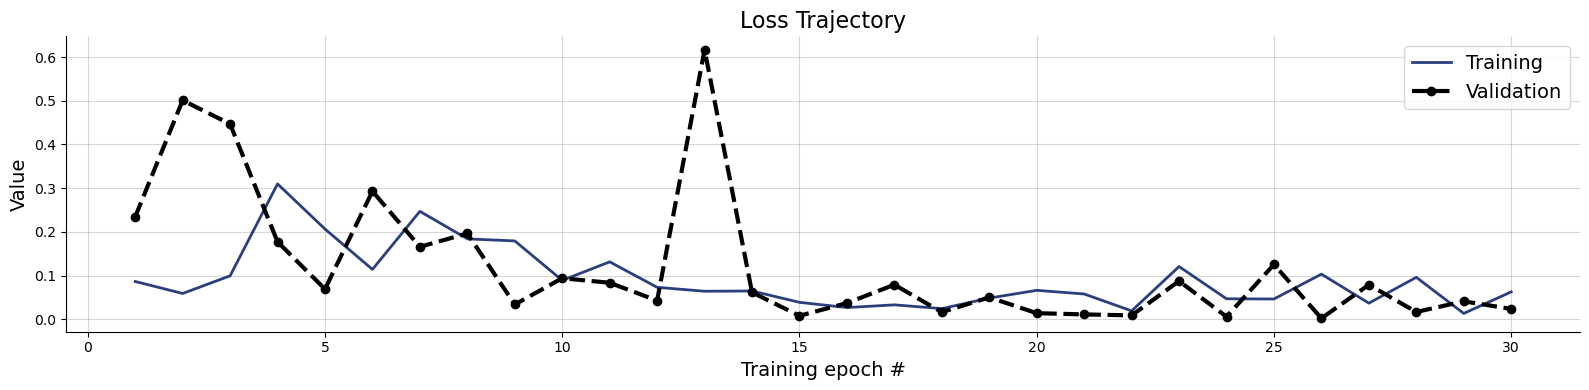

In [27]:
f = bf.diagnostics.plots.loss(history)

In [28]:
# # Set the number of posterior draws you want to get
# num_samples = 1000
num_test_samples = 500
test_idx = list(range(num_samples, num_samples + num_test_samples))

test_qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in test_idx]


In [29]:

test_observables = [np.load(path)['arr_0'] for path in test_qsp_paths]
test_observables = np.concatenate(test_observables, axis=0)
test_observables = observables_processor(test_observables)
test_params = params_processor(params_df,test_idx)

test_sims = {"kd": test_params, 
					"sim_data": test_observables}


time_series = test_sims.pop("sim_data")
num_posterior_samples = 500
samples = workflow.sample(conditions={"sim_data": time_series}, num_samples=num_posterior_samples)

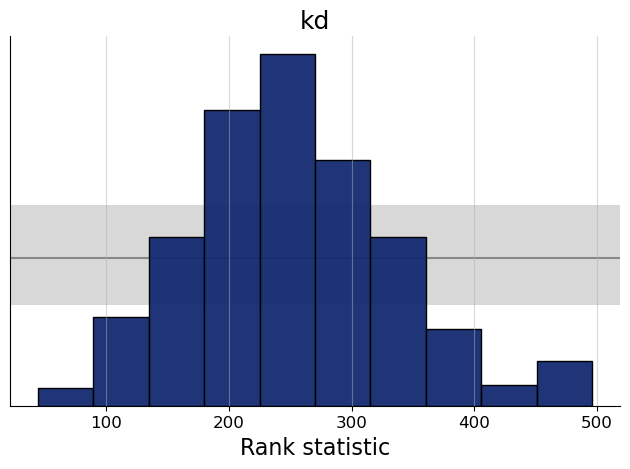

In [30]:
f = bf.diagnostics.plots.calibration_histogram(samples,test_sims)

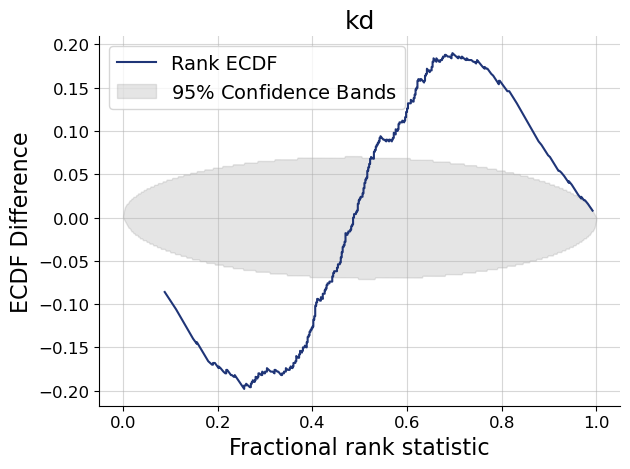

In [31]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

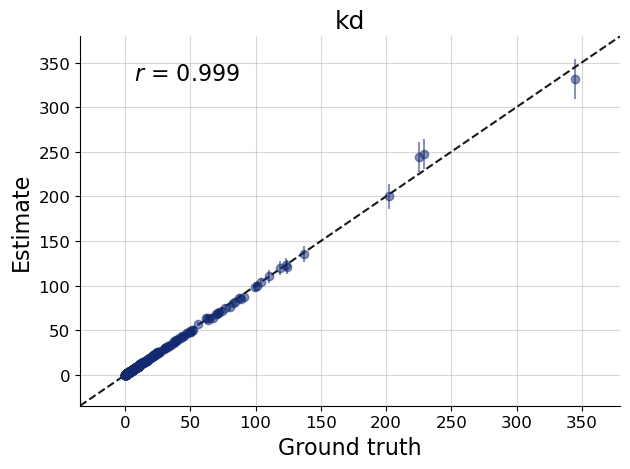

In [32]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

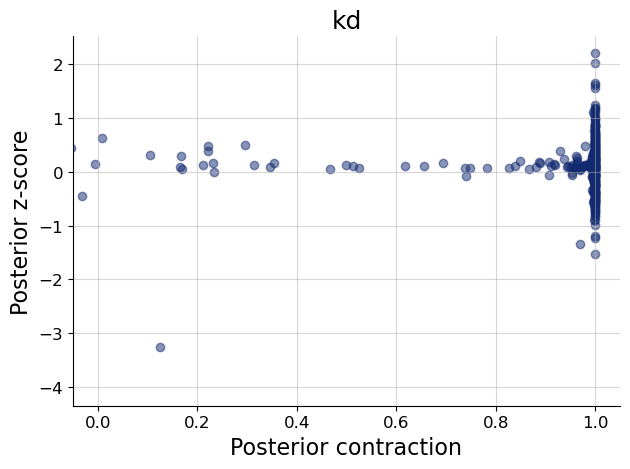

In [393]:
f = bf.diagnostics.plots.z_score_contraction(samples, test_sims)